# CO2 equilibrium runs

Recreate abrupt 4xCO2 runs from all 66 CMIP6 model calibrations and create Gregory plots.

This demonstrates the flexibility of FaIR in that it can be applied to mimic specific ESM experiments.

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd

from fair import FAIR
from fair.interface import fill, initialise

## 1. Create FaIR instance

In [3]:
f = FAIR()

## 2. Define time horizon

I want 1000 years, even though 4xCO2 is only 150 year experiment.

In [4]:
f.define_time(0, 1000, 1)
f.timebounds

array([   0.,    1.,    2., ...,  998.,  999., 1000.])

## 3. Define scenarios

This is easy: there's only one

In [5]:
f.define_scenarios(['abrupt-4xCO2'])

## 4. Define configs

In [6]:
df = pd.read_csv("../tests/test_data/4xCO2_cummins_ebm3.csv")
models = df['model'].unique()
configs = []

for imodel, model in enumerate(models):
    for run in df.loc[df['model']==model, 'run']:
        configs.append(f"{model}_{run}")
f.define_configs(configs)

## 5. Define species

Note we set the `input_mode` to forcing, as we are running with prescribed forcing from the 4xCO2 Gregory.

In [7]:
species = ['CO2']

In [8]:
properties = {
    'CO2': {
        'type': 'co2',
        'input_mode': 'forcing',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    },
}

In [9]:
f.define_species(species, properties)

## 6. Modifying run options

Not applicable

## 7. Create input and output data

In [10]:
f.allocate()

## 8. fill in everything

In [11]:
initialise(f.temperature, 0)

In [12]:
df = pd.read_csv("../tests/test_data/4xCO2_cummins_ebm3.csv")
models = df['model'].unique()

seed = 0

for config in configs:
    model, run = config.split('_')
    condition = (df['model']==model) & (df['run']==run)
    fill(f.climate_configs['ocean_heat_capacity'], df.loc[condition, 'C1':'C3'].values.squeeze(), config=config)
    fill(f.climate_configs['ocean_heat_transfer'], df.loc[condition, 'kappa1':'kappa3'].values.squeeze(), config=config)
    fill(f.climate_configs['deep_ocean_efficacy'], df.loc[condition, 'epsilon'].values[0], config=config)
    fill(f.climate_configs['gamma_autocorrelation'], df.loc[condition, 'gamma'].values[0], config=config)
    fill(f.climate_configs['sigma_eta'], df.loc[condition, 'sigma_eta'].values[0], config=config)
    fill(f.climate_configs['sigma_xi'], df.loc[condition, 'sigma_xi'].values[0], config=config)
    fill(f.climate_configs['stochastic_run'], True, config=config)
    fill(f.climate_configs['use_seed'], True, config=config)
    fill(f.climate_configs['seed'], seed, config=config)
    
    # We want to fill in a constant 4xCO2 forcing (for each model) across the run.
    fill(f.forcing, df.loc[condition, 'F_4xCO2'].values[0], config=config, specie='CO2')
    
    seed = seed + 10101

In [13]:
df

,model,run,conv,nit,gamma,C1,C2,C3,kappa1,kappa2,kappa3,epsilon,sigma_eta,sigma_xi,F_4xCO2
0,CAMS-CSM1-0,r1i1p1f1,True,4809,28.239872,2.632439,9.262195,52.927697,1.876254,5.153591,0.643546,1.285458,2.690512,0.439493,8.870602
1,GISS-E2-2-G,r1i1p1f1,True,3965,2.385368,3.601142,11.333337,313.520678,1.972359,1.922481,0.631276,0.443575,0.544189,0.535407,8.035197
2,NorESM2-LM,r1i1p1f1,True,1966,1.633858,4.487727,125.070697,0.041775,1.603670,0.823165,1.596259,0.836880,1.343506,0.698845,7.845990
3,ACCESS-ESM1-5,r1i1p1f1,True,3517,2.742392,3.767727,8.922353,87.066320,0.699550,3.583351,0.842623,1.557784,0.636709,0.604740,6.557606
4,HadGEM3-GC31-LL,r1i1p1f3,True,5953,3.129576,3.868931,9.254582,66.399919,0.611179,2.851391,0.642237,1.174268,0.457505,0.611576,7.222087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,TaiESM1,r1i1p1f1,True,6231,2.044911,5.064045,8.999461,91.069184,0.873504,2.314369,0.919607,1.233673,0.461613,0.687217,8.150058
62,NorESM2-MM,r1i1p1f1,True,2562,1.480571,4.121854,121.675907,0.049259,1.961781,0.788035,2.112814,0.528932,1.310908,0.661117,9.113671
63,HadGEM3-GC31-MM,r1i1p1f3,True,4790,3.131744,3.396641,14.143754,64.570893,0.646049,2.007478,0.693694,1.041912,0.497626,0.433937,7.159394
64,NESM3,r1i1p1f1,True,4634,2.798083,2.492649,19.210731,125.556294,0.964647,1.051545,0.478707,0.724899,0.546573,0.272723,8.151686


In [14]:
f.fill_species_configs()

In [15]:
fill(f.species_configs['tropospheric_adjustment'], 0, specie='CO2')

## 9. run FaIR

In [16]:
f.run()

/Users/ptg21/mambaforge/envs/base-ptg/lib/python3.11/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/Users/ptg21/mambaforge/envs/base-ptg/lib/python3.11/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/Users/ptg21/mambaforge/envs/base-ptg/lib/python3.11/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/Users/ptg21/mambaforge/envs/base-ptg/lib/python3.11/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/Users/ptg21/mambaforge/envs/base-ptg/lib/python3.11/site-packages/scipy/stats/_multivariate.py:

Running 66 projections in parallel:   0%|          | 0/1000 [00:00<?, ?timesteps/s]

## 10. Show results

Although we can get convincing internal variability for T and N individually, it appears that the stochastic variability is correlated.

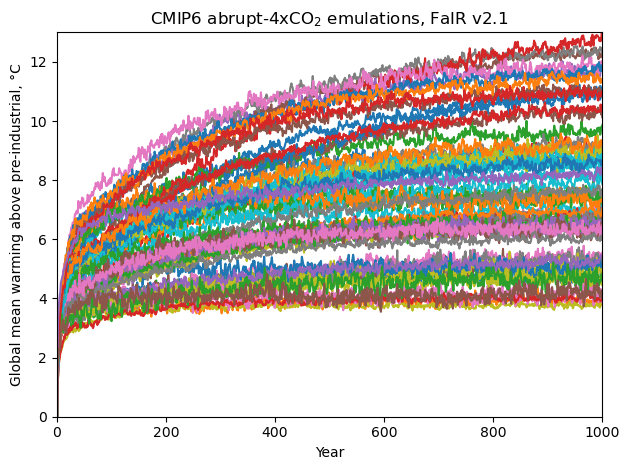

In [17]:
fig, ax = pl.subplots()
ax.plot(f.timebounds, f.temperature.loc[dict(layer=0, scenario='abrupt-4xCO2')]);
ax.set_xlim(0, 1000)
ax.set_ylim(0, 13)
ax.set_ylabel('Global mean warming above pre-industrial, °C')
ax.set_xlabel('Year')
ax.set_title('CMIP6 abrupt-4xCO$_2$ emulations, FaIR v2.1')
fig.tight_layout()

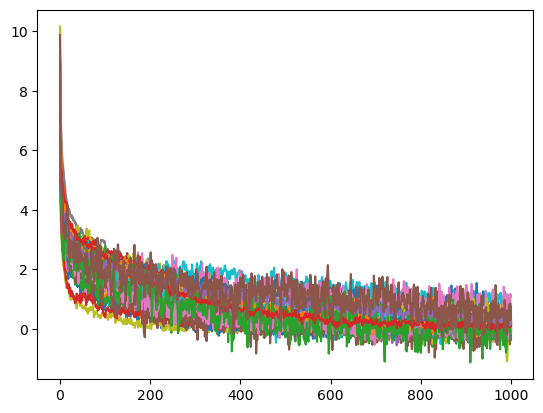

In [18]:
pl.plot(f.timebounds, f.toa_imbalance.loc[dict(scenario='abrupt-4xCO2')]);

In [ ]:
pl.plot(f.timebounds, f.forcing_sum.loc[dict(scenario='abrupt-4xCO2')]);

In [ ]:
pl.plot(f.timebounds[800:], f.toa_imbalance.loc[dict(scenario='abrupt-4xCO2')][800:,...])
pl.axhline(0, color='k')

In [ ]:
fig, ax = pl.subplots(11, 6, figsize=(16, 30))

for i, config in enumerate(configs):
    ax[i//6,i%6].scatter(f.temperature.loc[dict(layer=0, scenario='abrupt-4xCO2', config=config)], f.toa_imbalance.loc[dict(scenario='abrupt-4xCO2', config=config)])
    ax[i//6,i%6].set_xlim(0,13)
    ax[i//6,i%6].set_ylim(-1, 10)
    ax[i//6,i%6].axhline(0, color='k')
    ax[i//6,i%6].set_title(config, fontsize=6)